# Classification

## Objectives

*   Fit and evaluate a classification model to predict if a treatment will be successful or not.


## Inputs

* outputs/datasets/collection/FertilityTreatmentData.csv.gz
* Instructions from the notebooks 02 and 04 on which variables to use for data cleaning and feature engineering.

## Outputs

* Train set (features and target)
* Test set (features and target)
* Data cleaning and Feature Engineering pipeline
* Modeling pipeline
* Feature importance plot


---

## Change working directory

Change the working directory from its current folder to its parent folder
* Access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/jupyter_notebooks'

To make the parent of the current directory the new current directory:
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("A new current directory has been set")

A new current directory has been set


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor'

---

## Step 1: Load Data

In [4]:
import numpy as np
import pandas as pd

# Open dataset
df = pd.read_csv("outputs/datasets/collection/FertilityTreatmentData.csv.gz")
        
print(df.shape)
df.head(3)

(169616, 61)


/var/folders/ps/q2jlnsf17tx866fp04k_jkg00000gn/T/ipykernel_37799/3215408494.py:5: DtypeWarning: Columns (4,38,51) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("outputs/datasets/collection/FertilityTreatmentData.csv.gz")


,Patient age at treatment,Total number of previous IVF cycles,Total number of previous DI cycles,Total number of previous pregnancies - IVF and DI,Total number of previous live births - IVF or DI,Causes of infertility - tubal disease,Causes of infertility - ovulatory disorder,Causes of infertility - male factor,Causes of infertility - patient unexplained,Causes of infertility - endometriosis,...,Heart three weeks gestation,Heart three birth outcome,Heart three birth weight,Heart three sex,Heart three birth congenital abnormalities,Heart three delivery date,Patient ethnicity,Partner ethnicity,Partner Type,Partner age
0,45-50,3,0,0.0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,Black,Other,Male,NaN
1,18-34,0,0,NaN,NaN,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,White,Other,NaN,NaN
2,999,0,0,NaN,NaN,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,Other,Other,NaN,NaN


---

## Step 2: ML Pipeline with all data

#### ML pipeline for Data Cleaning and Feature Engineering

Custom Transformers:

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin


class FilterIVFTreatments(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.query(
            "`Main reason for producing embroys storing eggs` == 'Treatment - IVF'"
        )

class DropErroneousEntries(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(
            X[(X["Live birth occurrence"] == 1) & (X["Embryos transferred"] == 0)].index
        )

class ConvertToNumeric(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            # Replace '>3' with 4
            X[col] = X[col].replace(">3", 4)
            # Convert to numeric
            X[col] = pd.to_numeric(X[col])
        return X


class ConvertToIntegers(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            # Replace '>3' with 4 and convert to int
            X[col] = X[col].replace(">3", 4).astype(float).astype(int)
        return X


class FillSpermSource(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["Sperm source"] = X.apply(self._fill_sperm_source, axis=1)
        return X

    def _fill_sperm_source(self, row):
        if pd.isna(row["Sperm source"]):
            if not pd.isna(row["Sperm donor age at registration"]):
                return "Donor"
            else:
                return "Partner"
        return row["Sperm source"]


# Convert float values to integers and handle NaN values
class ConvertToIntAndReplace999(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Fill NaN with -1 and convert to int
        X["Date of embryo transfer"] = (
            X["Date of embryo transfer"].fillna(-1).astype(int)
        )
        # Replace 999 with 0
        X["Date of embryo transfer"] = X["Date of embryo transfer"].replace(999, 0)
        return X


# Replace missing values based on the "Embryos transferred" column
class ReplaceMissingValues(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["Date of embryo transfer"] = X.apply(self._replace_missing, axis=1)
        return X

    def _replace_missing(self, row):
        value = row["Date of embryo transfer"]
        if value == -1 and row["Embryos transferred"] == 0:
            return "NT"
        elif value == -1:
            return "Missing"
        return value


# Append strings based on the "Fresh cycle" and "Frozen cycle" values
class AppendCycleType(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["Date of embryo transfer"] = X.apply(self._append_cycle_type, axis=1)
        return X

    def _append_cycle_type(self, row):
        value = row["Date of embryo transfer"]
        if value not in ["NT", "Missing"]:
            if row["Fresh cycle"] == 1:
                value = f"{value} - fresh"
            elif row["Frozen cycle"] == 1:
                value = f"{value} - frozen"
            else:
                value = f"{value} - Mixed fresh/frozen"
        return value


class MicroInjectedEmbryos(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Embryos transferred from eggs micro-injected imputation
        missing_micro_injected = X[
            "Embryos transferred from eggs micro-injected"
        ].isna()
        ICSI = X["Specific treatment type"].str.contains("ICSI")
        # Only replace missing values
        X.loc[
            missing_micro_injected & ICSI,
            "Embryos transferred from eggs micro-injected",
        ] = X.loc[missing_micro_injected & ICSI, "Embryos transferred"]
        X.loc[
            missing_micro_injected & ~ICSI,
            "Embryos transferred from eggs micro-injected",
        ] = 0

        return X


class DonorAgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Mapping from donor age ranges to patient/partner age ranges
        self.egg_age_map = {
            'Between 21 and 25': '18-34',
            'Between 26 and 30': '18-34',
            'Between 31 and 35': '18-34',
            '>35': '38-39',
            '<= 20': '18-34'
        }
        self.sperm_age_map = {
            'Between 21 and 25': '18-34',
            'Between 26 and 30': '18-34',
            'Between 31 and 35': '18-34',
            'Between 36 and 40': '38-39',
            'Between 41 and 45': '43-44',
            '>45': '45-50',
            '<= 20': '18-34'
        }
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Egg donor age imputation
        X['Egg donor age at registration'] = X['Egg donor age at registration'].map(self.egg_age_map)
        missing_egg_age = (X['Egg donor age at registration'].isna()) & (X['Egg source'] == 'Patient')
        X.loc[missing_egg_age, 'Egg donor age at registration'] = X.loc[missing_egg_age, 'Patient age at treatment']
        X.rename(columns={'Egg donor age at registration': 'Patient/Egg provider age'}, inplace=True)
        
        # Sperm donor age imputation
        X['Sperm donor age at registration'] = X['Sperm donor age at registration'].map(self.sperm_age_map)
        missing_sperm_age = (X['Sperm donor age at registration'].isna()) & (X['Sperm source'] == 'Partner')
        X.loc[missing_sperm_age, 'Sperm donor age at registration'] = X.loc[missing_sperm_age, 'Partner age']
        X.rename(columns={'Sperm donor age at registration': 'Partner/Sperm provider age'}, inplace=True)

        # Drop the "Partner age" column
        X.drop(columns=['Partner age'], inplace=True)
        
        # Ensure no duplicate columns
        if X.columns.duplicated().any():
            raise ValueError("Duplicate column names found after transformation")
        
        return X


class FloatToIntTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.float_vars = None

    def fit(self, X, y=None):
        # Identify float columns
        self.float_vars = X.select_dtypes(include="float").columns.tolist()
        return self

    def transform(self, X):
        X = X.copy()
        for var in self.float_vars:
            X[var] = X[var].astype(int)
        return X


class EFlaggingTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        X["Embryos transferred"] = X.apply(self.append_e, axis=1)
        return X

    def append_e(self, row):
        if (
            row["Embryos transferred"] == 1
            and row["Elective single embryo transfer"] == 1
        ):
            return "1e"
        else:
            return row["Embryos transferred"]


class TypeOfCycleAppender(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_update):
        self.columns_to_update = columns_to_update

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        # Ensure columns have the correct data type to avoid issues
        for column in self.columns_to_update:
            X[column] = X[column].astype(str)

        # Apply transformation for frozen cycle
        for column in self.columns_to_update:
            X.loc[(X["Frozen cycle"] == 1) & (X[column] == "0"), column] = (
                "0 - frozen cycle"
            )

        # Apply transformation for fresh cycle
        X["Total embryos thawed"] = X["Total embryos thawed"].astype(str)
        X.loc[
            (X["Fresh cycle"] == 1) & (X["Total embryos thawed"] == "0"),
            "Total embryos thawed",
        ] = "0 - fresh cycle"

        return X


class DropRowsWith999(BaseEstimator, TransformerMixin):
    """
    Custom transformer to drop rows with the value "999" in any column.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        
        # Drop rows where any column has the value "999"
        X_filtered = X[(X != "999").all(axis=1)]
        
        return X_filtered


#### Pipeline

In [6]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import DropFeatures, SmartCorrelatedSelection
from feature_engine.imputation import ArbitraryNumberImputer, DropMissingData
from feature_engine.encoding import OneHotEncoder

# Columns to drop
columns_to_drop = [
    "Total number of previous DI cycles",
    "Main reason for producing embroys storing eggs",
    "Type of treatment - IVF or DI",
    "Donated embryo",
    "Eggs thawed (0/1)",
    "Year of treatment",
    "Number of live births",
    "Embryos stored for use by patient",
    "Fresh eggs stored (0/1)",
    "Heart three birth congenital abnormalities",
    "Heart two birth congenital abnormalities",
    "Heart three delivery date",
    "Heart three sex",
    "Heart three birth weight",
    "Heart three weeks gestation",
    "Heart three birth outcome",
    "Heart one birth congenital abnormalities",
    "Heart two birth weight",
    "Heart two delivery date",
    "Heart two sex",
    "Heart two weeks gestation",
    "Heart two birth outcome",
    "Heart one birth weight",
    "Heart one weeks gestation",
    "Heart one delivery date",
    "Heart one sex",
    "Heart one birth outcome",
    "Number of foetal sacs with fetal pulsation",
    "Early outcome",
    "Partner Type",
]

# Columns to be updated with the type of cycle
columns_to_update = [
    "Fresh eggs collected",
    "Total eggs mixed",
    "Total embryos created",
]


def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline(
        [
            # Data Cleaning Steps
            ("filter_ivf", FilterIVFTreatments()),
            ("drop_erroneous", DropErroneousEntries()),
            ("drop_columns", DropFeatures(features_to_drop=columns_to_drop)),
            (
                "convert_to_numeric",
                ConvertToNumeric(
                    columns=[
                        "Total number of previous pregnancies - IVF and DI",
                        "Total number of previous live births - IVF or DI",
                    ]
                ),
            ),
            (
                "zeros_imputer",
                ArbitraryNumberImputer(
                    arbitrary_number=0,
                    variables=[
                        "Total number of previous pregnancies - IVF and DI",
                        "Total number of previous live births - IVF or DI",
                    ],
                ),
            ),
            (
                "convert_to_int",
                ConvertToIntegers(
                    columns=[
                        "Total number of previous pregnancies - IVF and DI",
                        "Total number of previous live births - IVF or DI",
                    ]
                ),
            ),
            ("fill_sperm_source", FillSpermSource()),
            ("dot_to_int_999", ConvertToIntAndReplace999()),
            ("replace_missing_values", ReplaceMissingValues()),
            ("append_cycle_type", AppendCycleType()),
            ("micro_injected", MicroInjectedEmbryos()),
            ("donor_age", DonorAgeImputer()),
            ("float_to_int", FloatToIntTransformer()),
            ("e_flagging", EFlaggingTransformer()),
            ("type_of_cycle", TypeOfCycleAppender(columns_to_update=columns_to_update)),
            ("drop_999", DropRowsWith999()),
            ("drop_missing_data", DropMissingData()),

            # Feature Engineering Steps
            (
                "one_hot_encoding",
                OneHotEncoder(
                    drop_last=True,
                    variables=[
                        "Patient age at treatment",
                        "Total number of previous IVF cycles",
                        "Patient/Egg provider age",
                        "Partner/Sperm provider age",
                        "Specific treatment type",
                        "Egg source",
                        "Sperm source",
                        "Patient ethnicity",
                        "Partner ethnicity",
                        "Fresh eggs collected",
                        "Total eggs mixed",
                        "Total embryos created",
                        "Embryos transferred",
                        "Total embryos thawed",
                        "Date of embryo transfer",
                    ],
                ),
            ),
            
            (
                "smart_correlation",
                SmartCorrelatedSelection(
                    method="spearman", threshold=0.9
                ),
            ),
        ]
    )

    return pipeline_base


PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('filter_ivf', FilterIVFTreatments()),
                ('drop_erroneous', DropErroneousEntries()),
                ('drop_columns',
                 DropFeatures(features_to_drop=['Total number of previous DI '
                                                'cycles',
                                                'Main reason for producing '
                                                'embroys storing eggs',
                                                'Type of treatment - IVF or DI',
                                                'Donated embryo',
                                                'Eggs thawed (0/1)',
                                                'Year of treatment',
                                                'Number of live births',
                                                'Embryos stored for use by '
                                                'patien...
                                          'Total number of previous IVF cycles',
                                          'Patient/Egg provider age',
                                          'Partner/Sperm provider age',
                                          'Specific treatment type',
                                          'Egg source', 'Sperm source',
                                          'Patient ethnicity',
                                          'Partner ethnicity',
                                          'Fresh eggs collected',
                                          'Total eggs mixed',
                                          'Total embryos created',
                                          'Embryos transferred',
                                          'Total embryos thawed',
                                          'Date of embryo transfer'])),
                ('smart_correlation',
                 SmartCorrelatedSelection(method='spearman', threshold=0.9))])

### ML Pipeline for Modelling and Hyperparameter Optimisation

In [7]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
)
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("feat_selection", SelectFromModel(model)),
            ("model", model),
        ]
    )

    return pipeline_base

Custom Class for Hyperparameter Optimisation using GridSearchCV

In [8]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:
    
    def __init__(self, models, params):
        # Initialize with dictionaries of models and their corresponding hyperparameters
        self.models = models
        self.params = params
        # Store the keys (model names) for easy iteration
        self.keys = models.keys()  
        # Initialize an empty dictionary to store grid search results
        self.grid_searches = {}    

    def fit(self, X, y, cv, n_jobs=-1, verbose=1, scoring=None, refit="f1"):
        # Fit GridSearchCV for each model with provided data and parameters
        
        for key in self.keys:
            # Inform about the model being processed and the number of parameter combinations
            print(f"\nRunning GridSearchCV for {key} with {len(self.params[key])} parameter combinations.\n")

            # Create a model pipeline (PipelineClf)
            model = PipelineClf(self.models[key])
            
            # Retrieve the corresponding hyperparameters for the model
            params = self.params[key]
            
            # Set up the GridSearchCV with the model, parameters, and specified settings
            gs = GridSearchCV(
                model,
                params,
                cv=cv,           # Cross-validation strategy
                n_jobs=n_jobs,   # Number of parallel jobs (-1 means using all processors)
                verbose=verbose, # Verbosity level
                scoring=scoring, # Scoring metrics
                refit=refit,     # Metric to refit the model on after grid search
            )
            
            # Fit the model with the provided data (X and y)
            gs.fit(X, y)
            
            # Store the result of the grid search in the dictionary under the model's name
            self.grid_searches[key] = gs
            
    def score_summary(self, sort_by="f1", scoring=None):
        # Summarize and return the results of the grid search
        
        if scoring is None:
            # Ensure a scoring dictionary is provided; otherwise, raise an error
            raise ValueError("Scoring dictionary must be provided")
        
        # List to store rows for the summary DataFrame
        rows = []
        
        for k in self.grid_searches:
            # For each model, retrieve the grid search results
            
            # Get the hyperparameter combinations tested
            params = self.grid_searches[k].cv_results_["params"]
            
            # Retrieve the mean test scores for each metric
            mean_scores = {
                metric: self.grid_searches[k].cv_results_[f"mean_test_{metric}"]
                for metric in scoring.keys()
            }
            # For each parameter combination, create a dictionary of the results
            for i in range(len(params)):
                # Add model name and hyperparameters
                row_data = {"estimator": k, **params[i]}
                # Add mean scores for each metric (averaged across CV folds)
                row_data.update({f"mean_{metric}": mean_scores[metric][i] for metric in mean_scores})
                # Convert to a Pandas Series and add to the list
                rows.append(pd.Series(row_data))
        
        # Convert the list of Series into a DataFrame and sort it by the specified metric
        df = pd.DataFrame(rows).sort_values([f"mean_{sort_by}"], ascending=False)
        
        # Return the sorted DataFrame and the dictionary of grid search results
        return df, self.grid_searches


### Split Train and Test Set

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    # Do not drop the target column here because it is needed for the pipeline
    df,
    df["Live birth occurrence"],
    test_size=0.2,
    random_state=0,
)


## Handle Target Imbalance

Apply the data cleaning and feature engineering pipeline

In [10]:
X_train.head(3)

,Patient age at treatment,Total number of previous IVF cycles,Total number of previous DI cycles,Total number of previous pregnancies - IVF and DI,Total number of previous live births - IVF or DI,Causes of infertility - tubal disease,Causes of infertility - ovulatory disorder,Causes of infertility - male factor,Causes of infertility - patient unexplained,Causes of infertility - endometriosis,...,Heart three weeks gestation,Heart three birth outcome,Heart three birth weight,Heart three sex,Heart three birth congenital abnormalities,Heart three delivery date,Patient ethnicity,Partner ethnicity,Partner Type,Partner age
141611,40-42,1,0,NaN,0.0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,White,White,Male,45-50
98484,40-42,4,0,NaN,0.0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,White,White,Male,38-39
158125,38-39,0,0,NaN,NaN,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,White,White,Male,45-50


In [11]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)

In [12]:
X_train.head(3)

,Total number of previous pregnancies - IVF and DI,Total number of previous live births - IVF or DI,Causes of infertility - tubal disease,Causes of infertility - ovulatory disorder,Causes of infertility - male factor,Causes of infertility - patient unexplained,Causes of infertility - endometriosis,PGT-M treatment,PGT-A treatment,Embryos transferred from eggs micro-injected,...,Date of embryo transfer_2 - frozen,Date of embryo transfer_5 - Mixed fresh/frozen,Date of embryo transfer_7 - fresh,Date of embryo transfer_0 - fresh,Date of embryo transfer_1 - fresh,Date of embryo transfer_5 - frozen,Date of embryo transfer_6 - frozen,Date of embryo transfer_2 - Mixed fresh/frozen,Date of embryo transfer_7 - frozen,Date of embryo transfer_6 - Mixed fresh/frozen
141611,0,0,1,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
158125,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34201,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Realign y_train indices with the transformed X_train to keep only the rows present on the dataset after the cleaning step

In [13]:
y_train = y_train.loc[X_train.index]

Apply the pipeline to the test set and realign indices on y_test

In [14]:
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
y_test = y_test.loc[X_test.index]


Drop the target column from the processed X_train and X_test

In [15]:
X_train = X_train.drop(["Live birth occurrence"], axis=1)
X_test = X_test.drop(["Live birth occurrence"], axis=1)

In [16]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(108583, 96) (108583,) (27112, 96) (27112,)


Check Train Set Target distribution

0    77485
1    31098
Name: Live birth occurrence, dtype: int64


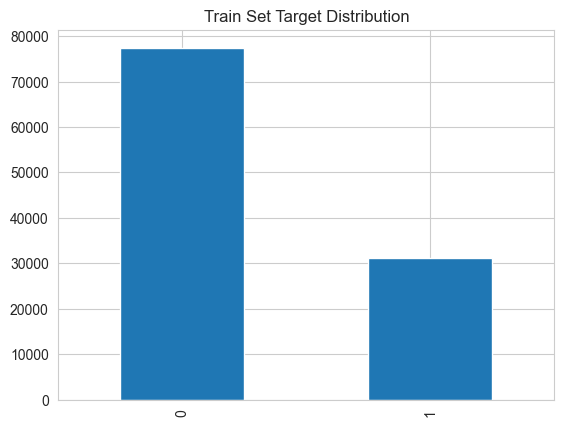

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

print(y_train.value_counts())

sns.set_style("whitegrid")
y_train.value_counts().plot(kind="bar", title="Train Set Target Distribution")
plt.show()

### Use SMOTE (Synthetic Minority Oversampling TEchnique) to balance Train Set target

In [18]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(154970, 96) (154970,) (27112, 96) (27112,)


Check Train Set Target distribution after resampling

1    77485
0    77485
Name: Live birth occurrence, dtype: int64


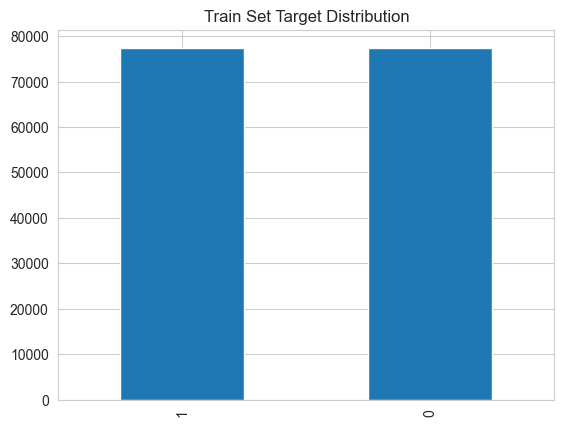

In [19]:
import matplotlib.pyplot as plt

print(y_train.value_counts())

y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

## Grid Search CV - Sklearn

### Use standard hyperparameters to find most suitable algorithm 

Set Up the Models and Parameters

In [20]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
    "XGBLogitBoost": XGBClassifier(objective="binary:logistic", random_state=0)
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
    "XGBLogitBoost": {}
}

Define the custom scoring metrics

In [21]:
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def npv_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fn)

# Dictionary of all the metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, pos_label=0),
    'specificity': make_scorer(specificity_score),
    'precision': make_scorer(precision_score, pos_label=1),
    'npv': make_scorer(npv_score),
    'mcc': make_scorer(matthews_corrcoef),
    'f1': make_scorer(f1_score, pos_label=1)
}

Quick GridSearch CV - Binary Classifier

In [22]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)

search.fit(X_train, y_train, cv=5, n_jobs=-1, scoring=scoring, refit='f1')


Running GridSearchCV for LogisticRegression with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Running GridSearchCV for XGBClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/patriciahalley/Documents/Code_institute/git/ivf-success-pred


Running GridSearchCV for XGBLogitBoost with 0 parameter combinations.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [23]:
# Get the results and sort by the F1 score
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='f1', scoring=scoring)
grid_search_summary


,estimator,mean_accuracy,mean_recall,mean_specificity,mean_precision,mean_npv,mean_mcc,mean_f1
3,RandomForestClassifier,0.708879,0.641001,0.641001,0.680991,0.757659,0.428032,0.722760
5,ExtraTreesClassifier,0.708524,0.663806,0.663806,0.688008,0.743385,0.424146,0.716003
6,AdaBoostClassifier,0.680590,0.562535,0.562535,0.643517,0.752771,0.378204,0.710859
2,DecisionTreeClassifier,0.689301,0.642240,0.642240,0.670648,0.720240,0.384682,0.699267
0,LogisticRegression,0.664787,0.545577,0.545577,0.631485,0.727226,0.343742,0.698150
1,XGBClassifier,0.653333,0.503349,0.503349,0.617461,0.726133,0.324484,0.697379
7,XGBLogitBoost,0.653333,0.503349,0.503349,0.617461,0.726133,0.324484,0.697379
4,GradientBoostingClassifier,0.648829,0.501142,0.501142,0.614413,0.720038,0.315368,0.692517


### Perform extensive and comprehensive search on the most suitable algorithm to find the best hyperparameter configuration using GridSearchCV

Define model and parameters, for Extensive Search

In [24]:
models_search = {
    'RandomForestClassifier': RandomForestClassifier ()
}

params_search = {
    'RandomForestClassifier': {
        'model__n_estimators': [100, 250, 500],
        'model__max_depth': [10, 20, 30],
        'model__min_samples_leaf': [5, 10, 20],
        'model__min_samples_split': [10, 15, 20],
        'model__max_features': ['sqrt', 'log2', 0.75],
        'model__class_weight': [{0: 1, 1: 2}, 'balanced_subsample', 'balanced'], 
    }
}

Extensive GridSearch CV - Binary Classifier

In [25]:
print(y_train.value_counts())

search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, cv=5, n_jobs=-1, scoring=scoring, refit='f1')

1    77485
0    77485
Name: Live birth occurrence, dtype: int64

Running GridSearchCV for RandomForestClassifier with 6 parameter combinations.

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Check results

In [26]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='f1', scoring=scoring)
grid_search_summary 

,estimator,model__class_weight,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__n_estimators,mean_accuracy,mean_recall,mean_specificity,mean_precision,mean_npv,mean_mcc,mean_f1
218,RandomForestClassifier,"{0: 1, 1: 2}",30,0.75,5,10,500,0.678899,0.468362,0.468362,0.624900,0.838735,0.406522,0.732316
135,RandomForestClassifier,"{0: 1, 1: 2}",20,0.75,5,10,100,0.670310,0.431787,0.431787,0.614540,0.852781,0.398159,0.732122
137,RandomForestClassifier,"{0: 1, 1: 2}",20,0.75,5,10,500,0.669710,0.430045,0.430045,0.614017,0.853401,0.397462,0.731900
162,RandomForestClassifier,"{0: 1, 1: 2}",30,sqrt,5,10,100,0.656553,0.373363,0.373363,0.599793,0.878509,0.386230,0.731760
136,RandomForestClassifier,"{0: 1, 1: 2}",20,0.75,5,10,250,0.669697,0.430574,0.430574,0.614048,0.852567,0.397126,0.731757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721,RandomForestClassifier,balanced,30,0.75,20,10,250,0.682777,0.596399,0.596399,0.652991,0.736763,0.377391,0.703732
481,RandomForestClassifier,balanced_subsample,30,0.75,20,15,250,0.682958,0.597574,0.597574,0.653263,0.736710,0.377686,0.703520
480,RandomForestClassifier,balanced_subsample,30,0.75,20,15,100,0.682345,0.596386,0.596386,0.652711,0.735974,0.376429,0.703209
484,RandomForestClassifier,balanced_subsample,30,0.75,20,20,250,0.682300,0.595973,0.595973,0.652558,0.736386,0.376506,0.703209


Get best model name programmatically

In [27]:
best_model = grid_search_summary.iloc[0,0]
best_model

'RandomForestClassifier'

Parameters for best model

In [28]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__class_weight': {0: 1, 1: 2},
 'model__max_depth': 30,
 'model__max_features': 0.75,
 'model__min_samples_leaf': 5,
 'model__min_samples_split': 10,
 'model__n_estimators': 500}

Define the best clf pipeline

In [29]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier())),
                ('model',
                 RandomForestClassifier(class_weight={0: 1, 1: 2}, max_depth=30,
                                        max_features=0.75, min_samples_leaf=5,
                                        min_samples_split=10,
                                        n_estimators=500))])

## Assess feature importance

In [30]:
X_train.head(3)

,Total number of previous pregnancies - IVF and DI,Total number of previous live births - IVF or DI,Causes of infertility - tubal disease,Causes of infertility - ovulatory disorder,Causes of infertility - male factor,Causes of infertility - patient unexplained,Causes of infertility - endometriosis,PGT-M treatment,PGT-A treatment,Embryos transferred from eggs micro-injected,...,Date of embryo transfer_2 - frozen,Date of embryo transfer_5 - Mixed fresh/frozen,Date of embryo transfer_7 - fresh,Date of embryo transfer_0 - fresh,Date of embryo transfer_1 - fresh,Date of embryo transfer_5 - frozen,Date of embryo transfer_6 - frozen,Date of embryo transfer_2 - Mixed fresh/frozen,Date of embryo transfer_7 - frozen,Date of embryo transfer_6 - Mixed fresh/frozen
0,0,0,1,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Assess feature importance on the current model with `.features_importances_`

* These are the 37 most important features in descending order. The model was trained on them: 
['Embryos transferred_0', 'Patient/Egg provider age_43-44', 'Patient age at treatment_40-42', 'Embryos transferred from eggs micro-injected', 'Total embryos created_0', 'Embryos transferred_1e', 'Total number of previous IVF cycles_1', 'Causes of infertility - male factor', 'Embryos transferred_2', 'Patient ethnicity_White', 'Total number of previous pregnancies - IVF and DI', 'Total embryos created_1-5', 'Partner ethnicity_White', 'Partner/Sperm provider age_18-34', 'Causes of infertility - patient unexplained', 'Partner/Sperm provider age_35-37', 'Specific treatment type_IVF', 'Total number of previous IVF cycles_2', 'Date of embryo transfer_5 - fresh', 'Partner/Sperm provider age_38-39', 'Total number of previous IVF cycles_0', 'Partner/Sperm provider age_40-42', 'Partner ethnicity_Other', 'Date of embryo transfer_3 - fresh', 'Total number of previous live births - IVF or DI', 'Patient ag

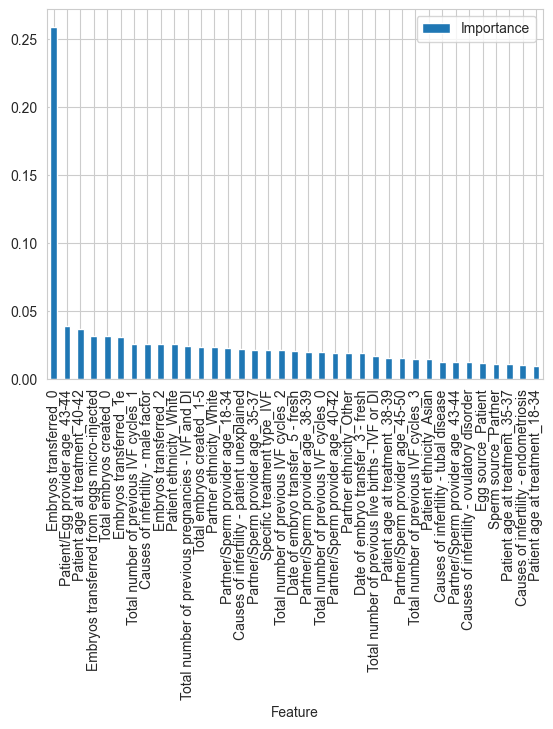

In [31]:
# create DataFrame to display feature importance
df_feature_importance = pd.DataFrame(
    data={
        "Feature": X_train.columns[pipeline_clf["feat_selection"].get_support()],
        "Importance": pipeline_clf["model"].feature_importances_,
    }
).sort_values(by="Importance", ascending=False)

# re-assign best_features order
best_features = df_feature_importance["Feature"].to_list()

# Most important features statement and plot
print(
    f"* These are the {len(best_features)} most important features in descending order. "
    f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}"
)

df_feature_importance.plot(kind="bar", x="Feature", y="Importance")
plt.show()

## Evaluate Pipeline on Train and Test Sets

In [32]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print("---  Confusion Matrix  ---")
    print(
        pd.DataFrame(
            confusion_matrix(y_true=prediction, y_pred=y),
            columns=[["Actual " + sub for sub in label_map]],
            index=[["Prediction " + sub for sub in label_map]],
        )
    )
    print("\n")

    print("---  Classification Report  ---")
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

Evaluation:

In [33]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['No Success', 'Success'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                      Actual No Success Actual Success
Prediction No Success             42428           3533
Prediction Success                35057          73952


---  Classification Report  ---
              precision    recall  f1-score   support

  No Success       0.92      0.55      0.69     77485
     Success       0.68      0.95      0.79     77485

    accuracy                           0.75    154970
   macro avg       0.80      0.75      0.74    154970
weighted avg       0.80      0.75      0.74    154970
 

#### Test Set ####

---  Confusion Matrix  ---
                      Actual No Success Actual Success
Prediction No Success              9205           1919
Prediction Success                10203           5785


---  Classification Report  ---
              precision    recall  f1-score   support

  No Success       0.83      0.47      0.60     19408
     Success       0.36      0.75      0.49      7704

    accuracy 

---